# Understanding GANs

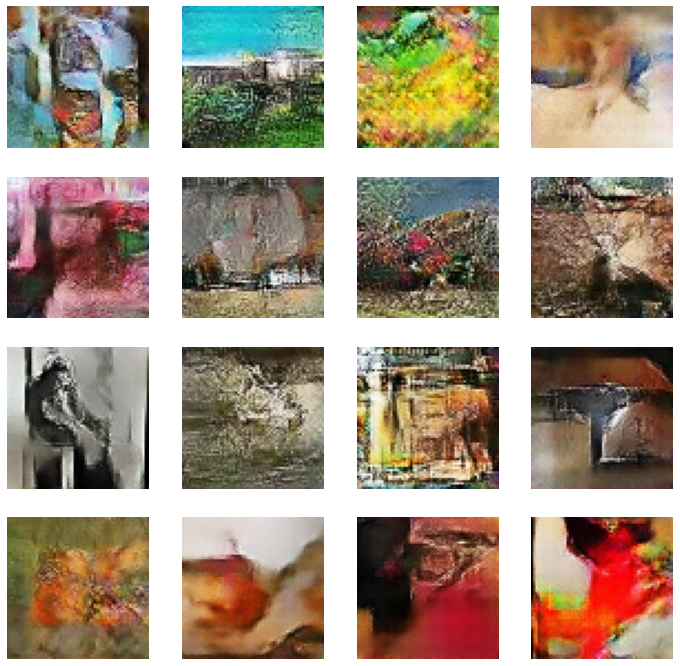

In [1]:
%load_ext tensorboard

In [2]:
rm -rf ./logs/

In [3]:
import tensorflow as tf
tf.config.list_physical_devices()

2022-06-14 18:29:37.011246: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 18:29:37.014285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 18:29:37.014394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Understanding the Difficulty in Training Gans

### Main Issues You May See 

Non-convergence: the models do not converge and worse they become unstable.

Mode collapse: the generator produces limited modes, and

Slow training: the gradient to train the generator vanished.

### What I will be focusing on

Minibatch Discrimination, which gives the discriminator a similarity of how similar images in a batch are (penalizes similar images in generator)

Feature Matching, aka: MSE(reduce_mean(real_emb, axis=0), reduce_mean(fake_emb, axis=0)) 

### Other Tips online on How to Train GANS

Scale the image pixel value between -1 and 1. 

Use tanh as the output layer for the generator.

Experiment sampling z with Gaussian distributions.

Batch normalization often stabilizes training.

Use PixelShuffle and transpose convolution for upsampling.

Avoid max pooling for downsampling. Use convolution stride.

Adam optimizer usually works better than other methods.

Add noise to the real and generated images before feeding them into the discriminator.

LeakyReLU activation.

Kernel size that is a factor of the stride size, 

Hyperbolic tangent (tanh)

## What made the most significant changes to my model:
#### Feature Matching loss only for generator 
#### Rescaling image to (-1, 1)

In [5]:
import glob
import datetime
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

## Data Preparation:

In [6]:
BATCH_SIZE = 512


import tensorflow_datasets as tfds

def rescale(x):
    return (x - 127.5) / 127.5

train_dataset = tf.keras.utils.image_dataset_from_directory(
    'tiny-imagenet-200',
    labels='inferred',
    label_mode=None,
    class_names=None,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(64, 64),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
).map(rescale, num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)


Found 120000 files belonging to 1 classes.


2022-06-14 18:29:39.605284: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-14 18:29:39.605733: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 18:29:39.605868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 18:29:39.605957: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

### Increase Epochs to 100 for better results!

In [7]:
EPOCHS = 20
noise_dim = 1000
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

## Model Creation: 
### (Based on https://www.tensorflow.org/tutorials/generative/dcgan)

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(noise_dim,), name="Gen_Dense_Create_Image"))
    model.add(layers.BatchNormalization(name="Gen_BN1"))
    model.add(layers.LeakyReLU(.2, name="Gen_Act1"))

    model.add(layers.Reshape((8, 8, 512), name="Gen_Reshape"))
    

    model.add(layers.Conv2DTranspose(512, (4, 4), strides=(1, 1), padding='same', use_bias=False, name="Gen_Conv1"))
    model.add(layers.BatchNormalization(name="Gen_BN2"))
    model.add(layers.LeakyReLU(.2, name="Gen_Act2"))

    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, name="Gen_Conv2"))
    model.add(layers.BatchNormalization(name="Gen_BN3"))
    model.add(layers.LeakyReLU(.2, name="Gen_Act3"))
    
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, name="Gen_Conv3"))
    model.add(layers.BatchNormalization(name="Gen_BN4"))
    model.add(layers.LeakyReLU(.2, name="Gen_Act4"))
    

    model.add(layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation='tanh', name="Gen_Output"))

    return model

2022-06-14 18:29:40.340743: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-14 18:29:40.595629: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-06-14 18:29:41.023605: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


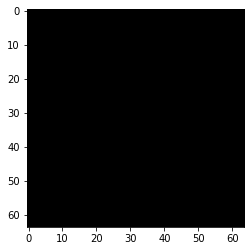

In [9]:
generator = make_generator_model()

noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(tf.cast(generated_image[0, :, :, :], tf.int32))

In [10]:
num_kernels = 5

nb_kernels = 5
kernel_dim = 3

from keras import backend as K

class make_discriminator_model(tf.keras.Model):
    def __init__(self):
        super(make_discriminator_model, self).__init__()
        
        self.layer1 = layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 3], use_bias=False, name="Discrim_Conv1")
        self.norm1 = layers.BatchNormalization(name="Discrim_BN1")
        self.act1 = layers.LeakyReLU(.2,  name="Discrim_Act1")
        self.dropout1 = layers.Dropout(0.3, name="Discrim_Dropout1")
        self.layer2 = layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, name="Discrim_Conv2")
        self.norm2 = layers.BatchNormalization(name="Discrim_BN2")
        self.act2 = layers.LeakyReLU(.2, name="Discrim_Act3")
        self.dropout2 = layers.Dropout(0.3, name="Discrim_Dropout2")
        self.layer3 = layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, name="Discrim_Conv3")
        self.norm3 = layers.BatchNormalization(name="Discrim_BN3")
        self.act3 = layers.LeakyReLU(.2, name="Discrim_Act3")
        self.dropout3 = layers.Dropout(0.3, name="Discrim_Dropout3")
        self.layer4 = layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same', use_bias=False, name="Discrim_Conv4")
        self.norm4 = layers.BatchNormalization(name="Discrim_BN4")
        self.act4 = layers.LeakyReLU(.2, name="Discrim_Act4")
        
        self.flatten_img = layers.Flatten(name="Discrim_Flatten_Img")
        self.transform_mat = tf.keras.layers.Dense(num_kernels*128, use_bias=False, name="Discrim_Mat_Dense")
        
        self.pool = layers.Flatten(name="Discrim_Flatten_Pool")

        
        self.out = layers.Dense(1, name="Discrim_Output")
        
    def call(self, img):
        x = self.layer1(img)
        x = self.norm1(x)
        x = self.act1(x)
        x = self.dropout1(x)
        x = self.layer2(x)
        x = self.norm2(x)
        x = self.act2(x)
        x = self.dropout2(x)
        x = self.layer3(x)
        x = self.norm3(x)
        x = self.act3(x)
        x = self.dropout3(x)
        
        x = self.layer4(x)
        x = self.norm4(x)

        
        x = self.act4(x)
        
        x = self.pool(x)
        
        img_vec = self.flatten_img(img)
        img_vec = self.transform_mat(img_vec)

        
        
        img_vec = tf.reshape(img_vec, [-1, num_kernels, 128])
        img_vec = img_vec[:, None] - img_vec
        similarity_mat = tf.exp(-tf.norm(img_vec, ord=1, axis=-1))
        sim_of_each_img = tf.reduce_sum(similarity_mat, axis=1)
        
        x = tf.concat([x, sim_of_each_img], axis=-1)
        
        x1 = x
        
        
        return self.out(x), x1

discriminator = make_discriminator_model()

## Loss Function:

In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_labels = tf.ones_like(real_output)
    real_labels += 0.1 * tf.random.uniform(tf.shape(real_labels))
    real_loss = cross_entropy(real_labels, real_output)
    
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss, real_loss, fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def feature_matching_generator_loss(real_images_embedding, generator_images_embedding):
    loss = tf.reduce_mean(tf.math.pow(
                            tf.reduce_mean(real_images_embedding, axis=0) 
                                     - tf.reduce_mean(generator_images_embedding, axis=0), 
                        2))
    
    return loss



generator_optimizer = tf.keras.optimizers.Adam(3e-4, beta_1=0.5,
    beta_2=0.999,)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5,
    beta_2=0.999,)

In [12]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [13]:
#checkpoint.read('./BestGAN')

## Training:

In [14]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output, real_emb = discriminator(images, training=True)
      fake_output, fake_emb = discriminator(generated_images, training=True)

      #gen_loss = generator_loss(fake_output)
      gen_loss = feature_matching_generator_loss(real_emb, fake_emb)
      disc_loss, real_loss, fake_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    gen_loss_metric.update_state(gen_loss)
    dim_real_loss.update_state(real_loss)
    dim_fake_loss.update_state(fake_loss)
    
    dim_real_acc.update_state(tf.ones_like(real_output), real_output)
    dim_fake_acc.update_state(tf.zeros_like(fake_output), fake_output)

In [15]:
gen_loss_metric = tf.keras.metrics.Mean()
dim_real_loss = tf.keras.metrics.Mean()
dim_fake_loss = tf.keras.metrics.Mean()

dim_real_acc = tf.keras.metrics.BinaryAccuracy()
dim_fake_acc = tf.keras.metrics.BinaryAccuracy()

plot_acc_real = []
plot_acc_fake = []

def train(dataset, epochs):
    
  for epoch in range(epochs):
    start = time.time()

    i = 0
    for image_batch in dataset:
        
      train_step(image_batch)
    
    
      i += 1
    

    display.clear_output(wait=True)
    generate_images(generator,
                             epoch + 1,
                             seed)

    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
    print ('Gen loss: {:.4f}\t Dim Real Acc/Loss: {:.4f} / {:.4f} \t Dim Fake Acc/Loss: {:.4f} / {:.4f}'.format(
        gen_loss_metric.result(), 
         dim_real_acc.result()*100, dim_real_loss.result(), 
        dim_fake_acc.result()*100, dim_fake_loss.result())
    )
    
    with train_summary_writer.as_default():
      tf.summary.scalar('Generator Loss', gen_loss_metric.result(), step=epoch)
      tf.summary.scalar('Discriminator on Real Accuracy', dim_real_acc.result(), step=epoch)
      tf.summary.scalar('Discriminator on Fake Accuracy', dim_fake_acc.result(), step=epoch)

    
    plot_acc_real.append(dim_real_acc.result()*100)
    plot_acc_fake.append(dim_fake_acc.result()*100)
    
    gen_loss_metric.reset_state()
    dim_real_loss.reset_state()
    dim_fake_loss.reset_state()
    dim_real_acc.reset_state()
    dim_fake_acc.reset_state()
    
    

  display.clear_output(wait=True)
  generate_images(generator,
                           epochs,
                           seed)

In [16]:
def generate_images(model, epoch, test_input):

  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(12, 12))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(tf.cast(predictions[i, :, :, :] * 127.5 + 127.5, tf.int32))
      plt.axis('off')

  plt.show()

In [18]:
#checkpoint.read('./BestGAN')

'./training_checkpoints\\ckpt-4'

In [17]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

train_summary_writer = tf.summary.create_file_writer(log_dir)


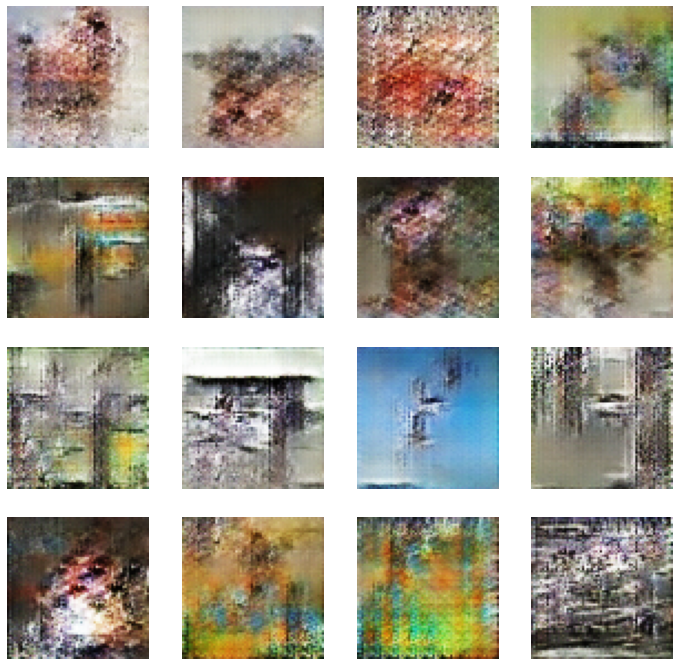

In [18]:
#Currently only at 20 Epochs!

tf.summary.trace_on(graph=True, profiler=True)
train(train_dataset, EPOCHS)

In [19]:
with train_summary_writer.as_default():
  tf.summary.trace_export(
      name="train_step_trace",
      step=0,
      profiler_outdir=log_dir)

Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2022-06-14 18:44:28.305686: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-14 18:44:28.349610: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-06-14 18:44:36.658862: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 2097153 callback api events and 2097153 activity events.  540614 events dropped because total driver(callback) events reaches max; 537909 events dropped because total device(activity) events reaches max.
2022-06-14 18:45:00.000629: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.


Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.


In [20]:
%tensorboard --logdir logs/fit

In [21]:
checkpoint.write('./BestGAN')

'./BestGAN'

## Older code for Hypertuning:
### (Not currently in use to avoid rerunning)


import optuna
import joblib

def create_model(trial):

    discriminator = make_discriminator_model()
    generator = make_generator_model()


    return discriminator, generator

def create_optimizer(trial):
    
    gen_lr = trial.suggest_float(
        "generator_lr", 1e-6, 1e-3, log=True
    )
    
    dim_lr = trial.suggest_float(
        "discriminator_lr", 1e-6, 1e-3, log=True
    )
    
    generator_optimizer = tf.keras.optimizers.Adam(gen_lr)
    discriminator_optimizer = tf.keras.optimizers.Adam(dim_lr)
    
    return discriminator_optimizer, generator_optimizer


def learn(discriminator, generator, discriminator_optimizer, generator_optimizer, dataset, dim_real_acc, dim_fake_acc, mode="eval"):

    for image_batch in dataset:
        noise = tf.random.normal([BATCH_SIZE, noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
          generated_images = generator(noise, training=True)

          real_output = discriminator(images, training=True)
          fake_output = discriminator(generated_images, training=True)

          gen_loss = generator_loss(fake_output)
          disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        dim_real_acc.update_state(tf.ones_like(real_output), real_output)
        dim_fake_acc.update_state(tf.zeros_like(fake_output), fake_output)


def objective(trial):

    discriminator, generator = create_model(trial)
    discriminator_optimizer, generator_optimizer = create_optimizer(trial)
    
    dim_real_acc = tf.keras.metrics.BinaryAccuracy()
    dim_fake_acc = tf.keras.metrics.BinaryAccuracy()

    for _ in range(100):
        dim_real_acc.reset_state()
        dim_fake_acc.reset_state()
        
        learn(discriminator, 
            generator, 
            discriminator_optimizer, 
            generator_optimizer, 
            train_dataset, 
            dim_real_acc, 
            dim_fake_acc, 
            "train"
        )
    
    
    res = abs((dim_real_acc.result()*100)-(dim_fake_acc.result()*100))


    return res



study = optuna.create_study(study_name="AccuracyMaximize", direction='maximize')
study.optimize(objective, n_trials=10)
joblib.dump(study, "study.pkl")

print(" Value: ", study.best_trial.value)
print(" Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

## Prior Images from Previous Training

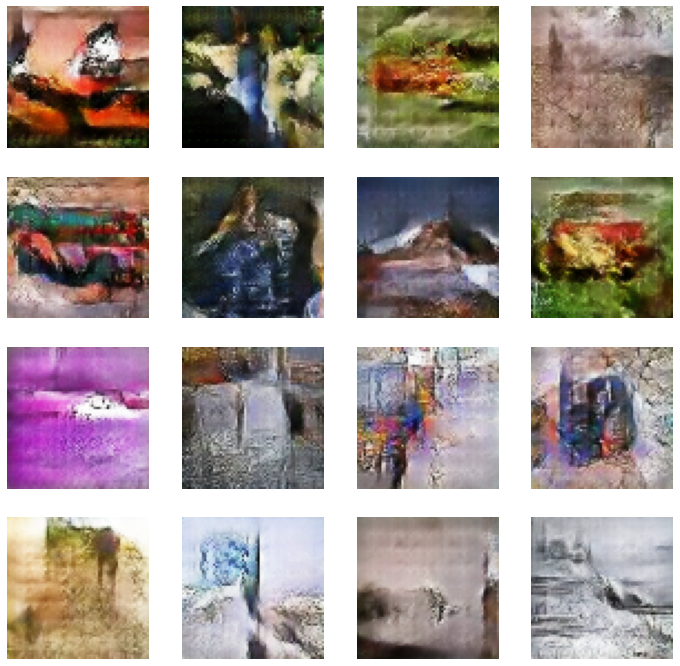

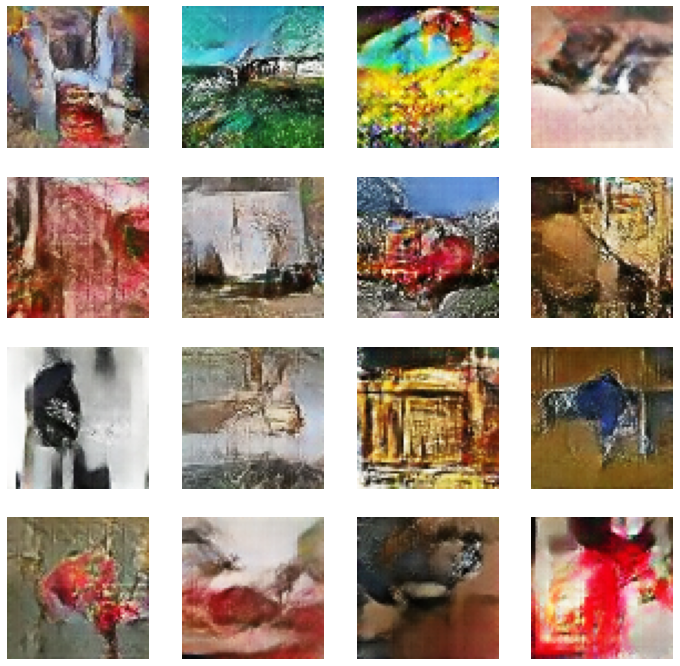

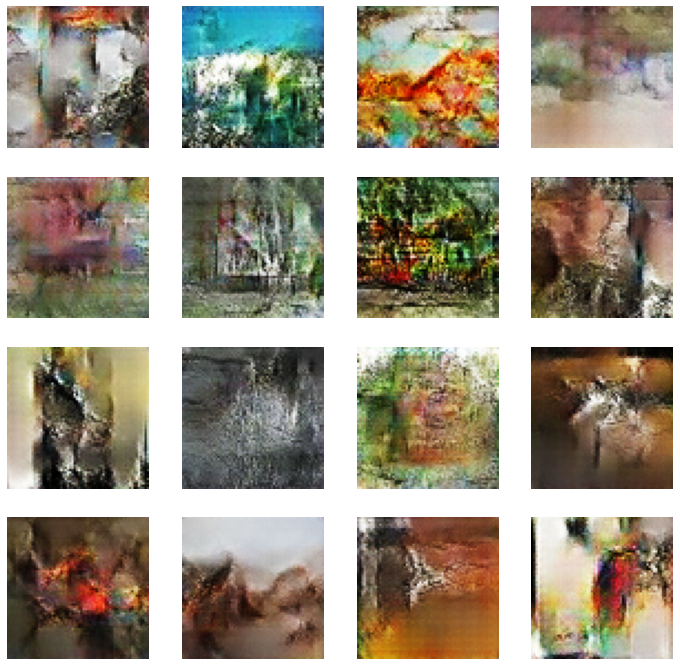

### Following Image was Before Rescaling and Feature Matching

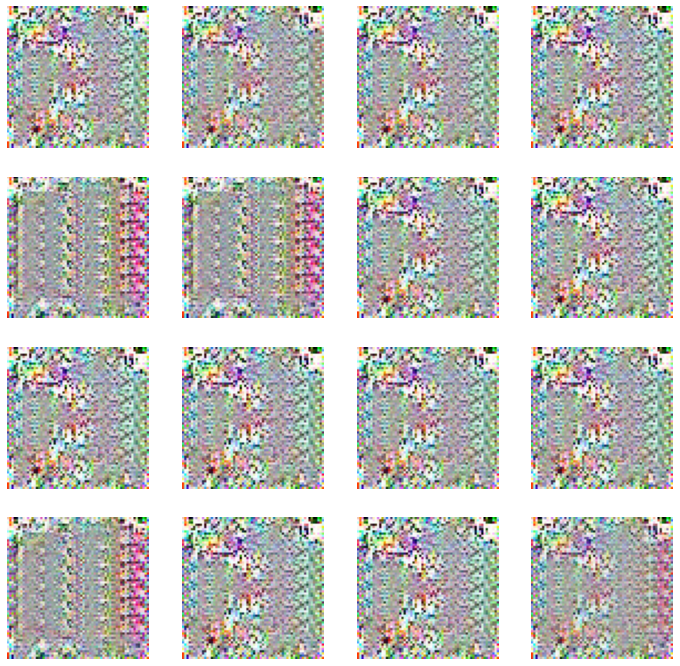

Gen loss: 14.8851	 
Dim Real Acc/Loss: 100.0000 / -388.0741 	 
Dim Fake Acc/Loss: 99.9959 / 0.0050